!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install datetime

In [17]:
import pandas as pd
import matplotlib
import pprint

matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
import seaborn as sns
import os
import re
import datetime
import numpy as np

In [18]:

# ====== GLOBAL VARS ===== #
filedir = '/Users/jiyoojeong/desktop/C/Nephila/renewables/raw/forwards/spg/'




In [19]:

# ====== FUNCTIONS ====== #


def combine_market(market):
    # list all in dir with name == to market

    lis = os.listdir(filedir)
    lis.remove('ERCOT')
    date = datetime.datetime.today()
    yesterday = (date - datetime.timedelta(days=1)).strftime("%m%d%Y")
    d = date.strftime("%m%d%Y")
    if True:#market + '_' + d + '.csv' not in os.listdir(filedir + 'ERCOT'):

        # print(d)
        print('Market: ' + market + '  Day: ' + d)
        big_one = pd.DataFrame()
        count = 0
        errors = 0
        for f in lis:
            try:
                if re.search(market, f) and not re.search('META', f):
                    #print('----- new -----')
                    df = pd.read_csv(filedir + f, engine='python')
                    #print('df read')
                    #print(f, df)
                    #print(df['Unnamed: 0.1'])
                    #print('helo')
                    #print('helllooo')
                    region = df.iloc[1, 1]
                    #print(region)
                    #break
                    region = region.split(':')[1].strip()
                    peak = df.iloc[3, 1]
                    peak = peak.split(':')[1].strip()
                    as_of_date = df.iloc[5, 1]  # accounts for weekend dates or days data is not available already
                    as_of_date = as_of_date.split(':')[1].strip()
                    headers = df.iloc[7, :].values
                    headers = np.delete(headers, 0)
                    #print('got all first 7 rows')

                    # print(region, peak, as_of_date, headers, type(region), type(headers))
                    #print(df.columns)
                    df = df.drop(df.index[[0, 1, 2, 3, 4, 5, 6, 7]])
                    df = df.drop(columns=[df.columns[0]])
                    #print('dropped columns')

                    #print(df.columns)
                    # change df to add new categorical parameters
                    df.columns = headers
                    #print(df.columns)
                    #print(df)
                    #break
                    df['AsOfDate'] = as_of_date

                    df['Peak'] = peak

                    df['Region'] = region

                    #print('set new columns')

                    # print(df)
                    # big_one.columns = headers
                    big_one = big_one.append(df)
                    #print('append to bigone')
                    # print(big_one)
            except:
                print('no settings like this one.', f)
                try:
                    print(df.iloc[6, :])
                except:
                    print(df)
                errors += 1
                #region2 = df.iloc[2, 1]
                #print(region2)
                #print(df.iloc[1, 1])
                ft = re.search(r'[0-9]{8}', f).span()
                wrongdate = f[ft[0]:ft[1]]
                print(wrongdate)
                print(datetime.datetime.strptime(wrongdate, '%m%d%Y').weekday())
                #break
            count += 1
            if count % 1000 == 0:
                # print(df)
                print(d)
                print(big_one.tail(10))
        os.chdir(filedir)
        # print(os.listdir(filedir))
        if market not in os.listdir(filedir):
            os.makedirs(market)
        bigfilename = filedir + market + '/' + market + '_' + str(d) + '.csv'
        big_one.to_csv(bigfilename)
        return bigfilename
    return filedir + market + '/' + market + '_' + d + '.csv'


def atc(on, off):
    # print(on[0], off[0])
    # print(type(on[0]), type(off[0]))
    b = (lambda x, y: (16.0 / 24) * x + (8.0 / 24 * 5 / 7 + 24 / 24 * 2 / 7) * y)(on.values, off.values)
    return b



In [20]:

# ====== ERCOT ====== #
ercot_files = os.listdir(filedir + 'ERCOT')
# print(ercot_files)
#ercot_file = filedir + 'ERCOT/' + 'ERCOT_07282020.csv'  # combine_market('ERCOT')
ercot_file = combine_market('ERCOT')
ercot = pd.read_csv(ercot_file)
# print(ercot.head())
ercot_cols_float = [u'AEN', u'CPS', u'DC_E', u'DC_N', u'DC_R',
                    u'Houston Zone', u'LCRA', u'North Zone', u'OKLA', u'South Zone',
                    u'West Zone']

for c in ercot_cols_float:
    ercot[c] = ercot[c].astype(float)

ercot['AsOfDate'] = pd.to_datetime(ercot['AsOfDate'])
ercot['Term'] = pd.to_datetime(ercot['Term'])
ercot = ercot.drop(columns=['Unnamed: 0'])
# ercot_early = ercot[ercot['AsOfDate'] <= datetime.datetime.strptime('12/31/2013', '%m/%d/%Y')].dropna()
sus = ercot.loc[ercot['Term'] == datetime.datetime.strptime('2019-08-01', '%Y-%m-%d'), : ]
sus = sus.loc[sus['AsOfDate'] == datetime.datetime.strptime('2019-08-19', '%Y-%m-%d'), :]


# get atc

zones = [u'Houston Zone', u'North Zone', u'South Zone', u'West Zone']

ercot_on = ercot.loc[ercot['Peak'] == 'On Peak', :].drop(columns=['Peak'])
ercot_off = ercot.loc[ercot['Peak'] == 'Off Peak', :].drop(columns=['Peak'])

# account for incompleteness?
ercot_on_off = ercot_on.merge(right=ercot_off, left_on=['AsOfDate', 'Term'],
                              right_on=['AsOfDate', 'Term'], how='left').assign(
    Houston=lambda df: atc(df['Houston Zone_x'], df['Houston Zone_y']),
    West=lambda df: atc(df['West Zone_x'], df['West Zone_y']),
    South=lambda df: atc(df['South Zone_x'], df['South Zone_y']),
    North=lambda df: atc(df['North Zone_x'], df['North Zone_y']))

ercot_atc = ercot_on_off[['AsOfDate', 'Term', 'Houston', 'West', 'South', 'North']]
ercot_atc = ercot_atc.rename(columns={'Houston': 'Houston Zone', 'West': 'West Zone',
                                      'South': 'South Zone', 'North': 'North Zone'})
ercot_atc['Peak'] = 'ATC'
ercot_atc['Region'] = 'ERCOT'
ercot = ercot[ercot_atc.columns]
ercot = ercot.append(ercot_atc).sort_values(by=['AsOfDate', 'Term', 'Peak']).drop_duplicates().dropna()


Market: ERCOT  Day: 08262020
no settings like this one. ERCOT_1_06102010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
06102010
3
no settings like this one. ERCOT_2_12142010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
12142010
1
no settings like this one. ERCOT_2_12042010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
12042010
5
no settings like this one. ERCOT_2_08262011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you.

no settings like this one. ERCOT_1_05142010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
05142010
4
no settings like this one. ERCOT_2_11102010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
11102010
2
no settings like this one. ERCOT_1_05042010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
05042010
1
no settings like this one. ERCOT_2_03272010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
032

no settings like this one. ERCOT_1_10312010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
10312010
6
no settings like this one. ERCOT_1_02062010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
02062010
5
no settings like this one. ERCOT_2_03082010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
03082010
0
no settings like this one. ERCOT_2_03182010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
031

no settings like this one. ERCOT_1_10172010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
10172010
6
no settings like this one. ERCOT_2_04132010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
04132010
1
no settings like this one. ERCOT_2_11192010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
11192010
4
no settings like this one. ERCOT_1_02202010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
022

no settings like this one. ERCOT_1_08142011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
08142011
6
no settings like this one. ERCOT_1_08042011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
08042011
3
no settings like this one. ERCOT_1_12262010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
12262010
6
no settings like this one. ERCOT_2_01292012.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
012

no settings like this one. ERCOT_1_10072011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
10072011
4
no settings like this one. ERCOT_2_11092011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
11092011
2
no settings like this one. ERCOT_2_04032011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
04032011
6
no settings like this one. ERCOT_1_03052010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
030

no settings like this one. ERCOT_2_12232011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
12232011
4
no settings like this one. ERCOT_2_07292011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
07292011
4
no settings like this one. ERCOT_1_06272011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
06272011
0
no settings like this one. ERCOT_2_08012010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
080

no settings like this one. ERCOT_2_02252011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
02252011
4
no settings like this one. ERCOT_2_05182011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
05182011
2
no settings like this one. ERCOT_2_10122011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
10122011
2
no settings like this one. ERCOT_1_04162011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
041

no settings like this one. ERCOT_2_01312011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
01312011
0
no settings like this one. ERCOT_2_09242010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
09242010
4
no settings like this one. ERCOT_2_01212011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
01212011
4
no settings like this one. ERCOT_1_07122011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
071

no settings like this one. ERCOT_1_07242011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
07242011
6
no settings like this one. ERCOT_2_08272011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
08272011
5
no settings like this one. ERCOT_1_09292011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
09292011
3
no settings like this one. ERCOT_2_12052010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
120

no settings like this one. ERCOT_1_04302011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
04302011
5
no settings like this one. ERCOT_2_10242011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
10242011
0
no settings like this one. ERCOT_1_04202011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
04202011
2
no settings like this one. ERCOT_1_04202010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
042

no settings like this one. ERCOT_1_06012011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
06012011
2
no settings like this one. ERCOT_2_12052011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
12052011
0
no settings like this one. ERCOT_1_09292010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
09292010
2
no settings like this one. ERCOT_2_08272010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
082

no settings like this one. ERCOT_2_02272010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
02272010
5
no settings like this one. ERCOT_2_10102010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
10102010
6
no settings like this one. ERCOT_1_04142010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
04142010
2
no settings like this one. ERCOT_1_04042010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
040

no settings like this one. ERCOT_2_08132011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
08132011
5
no settings like this one. ERCOT_2_02082010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
02082010
0
no settings like this one. ERCOT_1_03062010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
03062010
5
no settings like this one. ERCOT_1_03162010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
031

no settings like this one. ERCOT_2_03122010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
03122010
4
no settings like this one. ERCOT_2_03022010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
03022010
1
no settings like this one. ERCOT_1_08172011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
08172011
2
no settings like this one. ERCOT_2_09192011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
091

no settings like this one. ERCOT_1_07262011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
07262011
1
no settings like this one. ERCOT_2_06282011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
06282011
1
no settings like this one. ERCOT_2_01052011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
01052011
2
no settings like this one. ERCOT_2_09102010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
091

no settings like this one. ERCOT_2_10092011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
10092011
6
no settings like this one. ERCOT_2_05032011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
05032011
1
no settings like this one. ERCOT_1_11072011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
11072011
0
no settings like this one. ERCOT_1_03302011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
033

no settings like this one. ERCOT_1_05172011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
05172011
1
no settings like this one. ERCOT_2_11132011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
11132011
6
no settings like this one. ERCOT_2_04192011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
04192011
1
no settings like this one. ERCOT_1_12132011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
121

no settings like this one. ERCOT_2_04182010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
04182010
6
no settings like this one. ERCOT_1_05162010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
05162010
6
no settings like this one. ERCOT_2_10182010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
10182010
0
no settings like this one. ERCOT_2_05122010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
051

no settings like this one. ERCOT_2_06292010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
06292010
1
no settings like this one. ERCOT_2_01222012.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
01222012
6
no settings like this one. ERCOT_1_07272010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
07272010
1
no settings like this one. ERCOT_2_09112011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
091

no settings like this one. ERCOT_2_06062011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
06062011
0
no settings like this one. ERCOT_1_07082011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
07082011
4
no settings like this one. ERCOT_1_12022011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
12022011
4
no settings like this one. ERCOT_1_07182011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
071

no settings like this one. ERCOT_2_11242011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
11242011
3
no settings like this one. ERCOT_2_03132011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
03132011
6
no settings like this one. ERCOT_2_03032011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
03032011
3
no settings like this one. ERCOT_1_03072011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
030

no settings like this one. ERCOT_2_09272010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
09272010
0
no settings like this one. ERCOT_1_08292010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
08292010
6
no settings like this one. ERCOT_2_01222011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
01222011
5
no settings like this one. ERCOT_1_07112011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
071

no settings like this one. ERCOT_1_08062011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
08062011
5
no settings like this one. ERCOT_1_08162011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
08162011
1
no settings like this one. ERCOT_2_09182011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
09182011
6
no settings like this one. ERCOT_2_07052011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
070

no settings like this one. ERCOT_1_08132011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
08132011
5
no settings like this one. ERCOT_1_08032011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
08032011
2
no settings like this one. ERCOT_2_03162010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
03162010
1
no settings like this one. ERCOT_1_02182010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
021

no settings like this one. ERCOT_2_01082011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
01082011
5
no settings like this one. ERCOT_1_12312011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
12312011
5
no settings like this one. ERCOT_2_06252011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
06252011
5
no settings like this one. ERCOT_1_12212011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
122

no settings like this one. ERCOT_1_12282010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
12282010
1
no settings like this one. ERCOT_1_07222010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
07222010
3
no settings like this one. ERCOT_2_01272012.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
01272012
4
no settings like this one. ERCOT_2_09042011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
090

   Unnamed: 0                    Power Forwards & Futures (Data)
0           0                        Source: OTC Global Holdings
1           1                                      Region: ERCOT
2           2                              Forward Term: Monthly
3           3                                     Peak: Off Peak
4           4                                  As Of: 03/16/2013
5           5  No data matches your settings. Please edit you...
03162013
5
no settings like this one. ERCOT_1_10192011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
10192011
2
no settings like this one. ERCOT_1_05132011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
05132011
4
no settings like this one. ERC

no settings like this one. ERCOT_2_06032010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
06032010
3
no settings like this one. ERCOT_2_01082012.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
01082012
6
no settings like this one. ERCOT_1_12072010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
12072010
1
no settings like this one. ERCOT_1_12172010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
121

no settings like this one. ERCOT_2_09142010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
09142010
1
no settings like this one. ERCOT_2_01012011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
01012011
5
no settings like this one. ERCOT_2_09042010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
09042010
5
no settings like this one. ERCOT_2_01112011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
011

no settings like this one. ERCOT_1_06292010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
06292010
1
no settings like this one. ERCOT_1_01222012.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
01222012
6
no settings like this one. ERCOT_2_07272010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
07272010
1
no settings like this one. ERCOT_1_09012011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
090

no settings like this one. ERCOT_1_09112010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
09112010
5
no settings like this one. ERCOT_1_01042011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
01042011
1
no settings like this one. ERCOT_1_09012010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
09012010
2
no settings like this one. ERCOT_1_01142011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
011

no settings like this one. ERCOT_2_08202011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
08202011
5
no settings like this one. ERCOT_1_03252010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
03252010
3
no settings like this one. ERCOT_1_11122010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
11122010
4
no settings like this one. ERCOT_1_04182010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
041

no settings like this one. ERCOT_2_10052011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
10052011
2
no settings like this one. ERCOT_2_02222011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
02222011
1
no settings like this one. ERCOT_1_01222011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
01222011
5
no settings like this one. ERCOT_1_09272010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
092

no settings like this one. ERCOT_1_01142012.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
01142012
5
no settings like this one. ERCOT_2_07112010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
07112010
6
no settings like this one. ERCOT_2_07012010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
07012010
3
no settings like this one. ERCOT_1_01042012.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
010

no settings like this one. ERCOT_2_05202011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
05202011
4
no settings like this one. ERCOT_1_11242011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
11242011
3
no settings like this one. ERCOT_2_05302011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
05302011
0
no settings like this one. ERCOT_1_03032011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
030

no settings like this one. ERCOT_1_11102011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
11102011
3
no settings like this one. ERCOT_2_05142011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
05142011
5
no settings like this one. ERCOT_2_05042011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
05042011
2
no settings like this one. ERCOT_1_02022010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
020

no settings like this one. ERCOT_2_08222011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
08222011
0
no settings like this one. ERCOT_2_12102010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
12102010
4
no settings like this one. ERCOT_1_06142010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
06142010
0
no settings like this one. ERCOT_1_06042010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
060

no settings like this one. ERCOT_2_10072011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
10072011
4
no settings like this one. ERCOT_1_11092011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
11092011
2
no settings like this one. ERCOT_1_04032011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
04032011
6
no settings like this one. ERCOT_1_11192011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
111

no settings like this one. ERCOT_2_09212010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
09212010
1
no settings like this one. ERCOT_2_06092011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
06092011
3
no settings like this one. ERCOT_1_07072011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
07072011
3
no settings like this one. ERCOT_1_07172011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
071

no settings like this one. ERCOT_2_08042010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
08042010
2
no settings like this one. ERCOT_1_08102010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
08102010
1
no settings like this one. ERCOT_1_07282011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
07282011
3
no settings like this one. ERCOT_1_12222011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
122

no settings like this one. ERCOT_1_01212011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
01212011
4
no settings like this one. ERCOT_1_01312011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
01312011
0
no settings like this one. ERCOT_1_09242010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
09242010
4
no settings like this one. ERCOT_2_07022011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
070

no settings like this one. ERCOT_1_03102010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
03102010
2
no settings like this one. ERCOT_2_05232010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
05232010
6
no settings like this one. ERCOT_2_10292010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
10292010
4
no settings like this one. ERCOT_1_11272010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
112

no settings like this one. ERCOT_2_02212010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
02212010
6
no settings like this one. ERCOT_1_11082010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
11082010
0
no settings like this one. ERCOT_1_04022010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
04022010
4
no settings like this one. ERCOT_2_10062010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
100

no settings like this one. ERCOT_1_12152011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
12152011
3
no settings like this one. ERCOT_2_06112011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
06112011
5
no settings like this one. ERCOT_2_09292010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
09292010
2
no settings like this one. ERCOT_1_08272010.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
082

no settings like this one. ERCOT_2_05052011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
05052011
3
no settings like this one. ERCOT_1_11012011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
11012011
1
no settings like this one. ERCOT_1_11112011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
11112011
4
no settings like this one. ERCOT_2_05152011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
051

no settings like this one. ERCOT_1_02032011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
02032011
3
no settings like this one. ERCOT_1_02132011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
02132011
6
no settings like this one. ERCOT_1_10242011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
10242011
0
no settings like this one. ERCOT_2_04202011.csv
Unnamed: 0                                                                         6
Power Forwards & Futures (Data)    No data matches your settings. Please edit you...
Name: 6, dtype: object
042

In [26]:
ercot[ercot['West Zone'] > 100]['Term'].dt.month.value_counts()
# months with forward prices greater than 100
# these are all summer months

8    5746
7    1389
6      13
9       2
Name: Term, dtype: int64

In [27]:
ercot.to_csv('/Users/jiyoojeong/desktop/c/nephila/renewables/ercot_all_ATC2.csv')

In [28]:
ercot['Peak'].value_counts()

Monthly    618866
Name: Peak, dtype: int64

In [29]:

''' Now we want to get the value difference from the historical to the predicted.'''
''' 
TODO:
- import the historical prices
- match each term date to each historical date
- find the difference
- use this difference as the new values for delta
'''

ERCOT_RT = pd.read_csv('/Users/jiyoojeong/desktop/C/Nephila/renewables/raw/reals/ERCOT/ERCOT_RT.csv')
ERCOT_RT['date'] = pd.to_datetime(ERCOT_RT['date'])
ERCOT_RT['price'] = ERCOT_RT['price'].astype(float)
print(ERCOT_RT)

ercot_zones = pd.melt(ercot,id_vars=['AsOfDate', 'Term', 'Peak'],
                           value_vars=zones,
                           var_name='Subregion')
#print(ercot_zones)
# ercot_rt_reshaped = ERCOT_RT.pivot(index='date', columns=['Peak', 'Subregion'])
# print(ercot_rt_reshaped)

# ercot = ercot.loc[['Houston Zone', 'North Zone', 'South Zone', 'West Zone']]
# ercot_early = ercot.append(ercot_atc).sort_values(by=['AsOfDate', 'Term', 'Peak'])
# TODO: Some magic and find the differences between prices for each term, peak, and region.
ercot_zones.sort_values('value', ascending=False).head(20)


            date      price      Peak     Subregion
0     2010-12-01  24.566667       ATC  Houston Zone
1     2010-12-02  24.228333       ATC  Houston Zone
2     2010-12-03  25.019583       ATC  Houston Zone
3     2010-12-04  23.792188       ATC  Houston Zone
4     2010-12-05  25.658917       ATC  Houston Zone
...          ...        ...       ...           ...
37637 2020-05-30  19.289896  Off Peak     West Zone
37638 2020-05-31  16.022083  Off Peak     West Zone
37639 2020-06-01  16.313958  Off Peak     West Zone
37640 2020-06-02  16.181458  Off Peak     West Zone
37641 2020-06-03  16.717813  Off Peak     West Zone

[37642 rows x 4 columns]


,AsOfDate,Term,Peak,Subregion,value
1162612,2019-08-19,2019-08-01,Monthly,North Zone,402.9299
2400344,2019-08-19,2019-08-01,Monthly,West Zone,402.8399
1781478,2019-08-19,2019-08-01,Monthly,South Zone,399.2099
543746,2019-08-19,2019-08-01,Monthly,Houston Zone,291.2799
1162853,2019-08-20,2019-08-01,Monthly,North Zone,290.9699
2400585,2019-08-20,2019-08-01,Monthly,West Zone,290.8999
1163093,2019-08-21,2019-08-01,Monthly,North Zone,288.4855
2400825,2019-08-21,2019-08-01,Monthly,West Zone,288.4359
1781719,2019-08-20,2019-08-01,Monthly,South Zone,287.2299
1781959,2019-08-21,2019-08-01,Monthly,South Zone,287.0499


In [31]:

ercot_rt_h = ERCOT_RT.merge(ercot_zones, left_on=['date', 'Peak', 'Subregion'], right_on=['Term', 'Peak', 'Subregion'], how='inner')
#print(ercot_rt_h.head())

ercot_rt_h['Prediction Loss'] = ercot_rt_h['price'] - ercot_rt_h['value']
ercot_rt_h.sort_values('Prediction Loss')

ercot_rt_h.to_csv('/Users/jiyoojeong/desktop/c/nephila/renewables/realtime_forwards_ercot.csv')

In [ ]:

ercot_delta = ercot_rt_h.copy()
# ercot_delta_early = ercot_early.copy()
# monthly window averages
# ercot_delta = ercot.sort_values(by=['Term', 'AsOfDate']).rolling(30, min_periods=1).mean()

# day differences from predicted term date and the as of date
ercot_delta['Time Delta'] = ercot_delta['Term'] - ercot_delta['AsOfDate']
# ercot_delta_early['Time Delta'] = ercot_delta_early['Term'] - ercot_delta_early['AsOfDate']
# print(ercot_delta.head())
# drop index to make uniform
ercot_delta.reset_index(drop=True, inplace=True)
# melt columns so that the remaining columns are Delta Peak Subregion Value

#real_ercot = ercot_delta.loc[ercot_delta['Term'] == datetime.datetime.strptime('2020-01-01', '%Y-%m-%d')]
#real_ercot = ercot_delta.copy() # LOOK AT 10 YEARS
real_ercot = ercot_delta[ercot_delta['Time Delta'] <= datetime.timedelta(days=365)] #LOOKING ONLY AT ONE YEAR

real_ercot

In [52]:
real_ercot[real_ercot['Prediction Loss']>70]['Term'].value_counts()

2019-09-01    272
Name: Term, dtype: int64

In [53]:
# may also need to look at https://stackoverflow.com/questions/55403008/pandas-partial-melt-or-group-melt

ercot_delta_melt = real_ercot.drop_duplicates()#.drop(columns=['date', 'Term', 'AsOfDate'])
#print(ercot_delta_melt.sort_values(['Time Delta', 'Subregion', 'Peak'], ascending=True).tail(20))
# group column 'Delta' and find statistics

# mean
ercot_delta_avg = ercot_delta_melt.groupby(['Time Delta', 'Peak', 'Subregion']).mean()
#print(ercot_delta_avg)
# standard deviation
ercot_delta_sd = ercot_delta_melt.groupby(['Time Delta', 'Peak', 'Subregion']).std()
# max
ercot_delta_max = ercot_delta_melt.groupby(['Time Delta', 'Peak', 'Subregion']).max()
# min
ercot_delta_min = ercot_delta_melt.groupby(['Time Delta','Peak', 'Subregion']).min()

In [54]:
#ercot_delta_avg, ercot_delta_max, ercot_delta_min
ercot_delta_max

date       price   AsOfDate       Term  \
Time Delta Peak     Subregion                                                   
-30 days   ATC      Houston Zone 2018-12-01   44.587528 2018-12-31 2018-12-01   
                    North Zone   2018-12-01   45.858514 2018-12-31 2018-12-01   
                    South Zone   2018-12-01   44.507042 2018-12-31 2018-12-01   
                    West Zone    2018-12-01   46.724097 2018-12-31 2018-12-01   
           Off Peak Houston Zone 2018-12-01   61.813229 2018-12-31 2018-12-01   
...                                     ...         ...        ...        ...   
365 days   Off Peak West Zone    2019-11-01   41.276250 2018-11-01 2019-11-01   
           On Peak  Houston Zone 2020-05-01  102.315781 2019-05-02 2020-05-01   
                    North Zone   2020-07-01   64.485781 2019-07-02 2020-07-01   
                    South Zone   2020-05-01   67.969375 2019-05-02 2020-05-01   
                    West Zone    2020-05-01   63.853906 2019-05-02 2020-05-01   

                                       value  Prediction Loss  
Time Delta Peak     Subregion                                  
-30 days   ATC      Houston Zone   99.080762         4.339452  
                    North Zone     60.712857         4.008861  
                    South Zone     75.123810         2.848948  
                    West Zone      66.667143         5.140649  
           Off Peak Houston Zone   50.275200        36.733229  
...                                      ...              ...  
365 days   Off Peak West Zone      43.140000        22.376250  
           On Peak  Houston Zone  118.866900        64.045781  
                    North Zone    122.691900        31.345781  
                    South Zone    124.257200        31.359375  
                    West Zone     120.410200        33.793906  

[4752 rows x 6 columns]

In [55]:
%matplotlib inline

## PLOT 1 - MEAN


In [56]:
s_in_yr = 60*60*24*365
def timeTicks(s, pos):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
    return str(s)
                                                                                                                                                                                                        
formatter = matplotlib.ticker.FuncFormatter(timeTicks)  


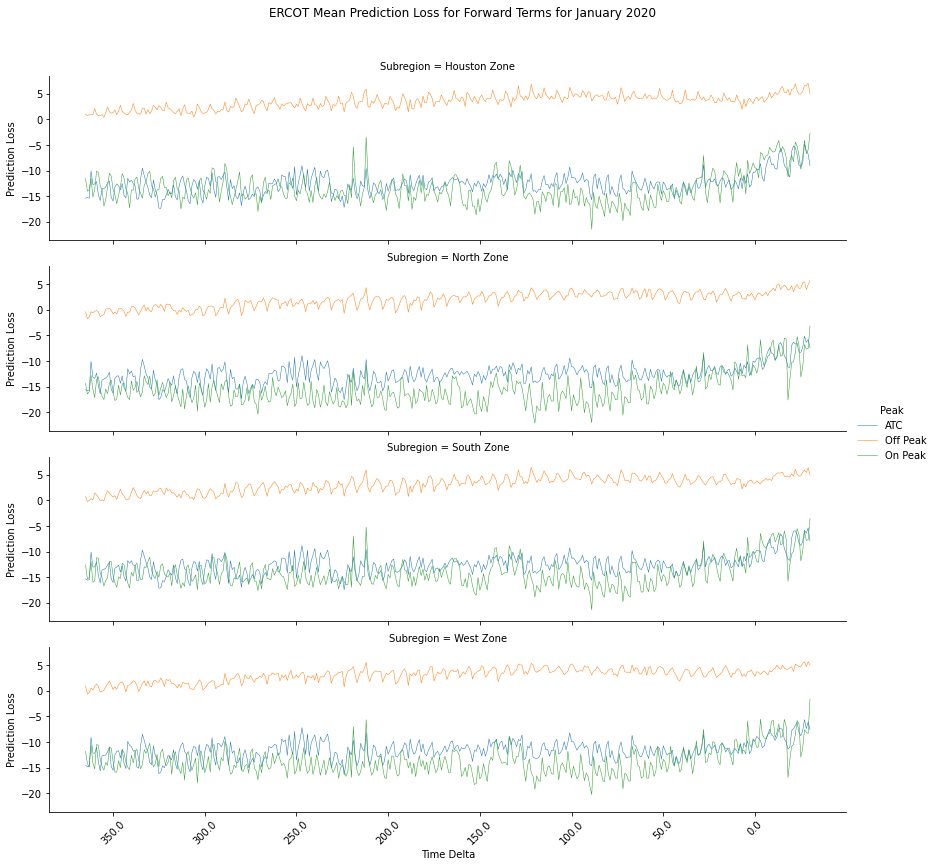

In [57]:
# os.chdir('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/')
#if 'figures' not in os.listdir('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/'):
#    os.makedirs('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/figures')

# plot to see
ercot_delta_avg = ercot_delta_avg.reset_index()
ercot_delta_avg['Time Delta'] = ercot_delta_avg['Time Delta'].dt.days
#print(ercot_delta_avg)
g = sns.FacetGrid(ercot_delta_avg, col="Subregion", hue='Peak', col_wrap=1, aspect=4)
g.map(plt.plot, 'Time Delta', 'Prediction Loss', linewidth=.5).add_legend()
plt.subplots_adjust(top=.9)
g.fig.suptitle('ERCOT Mean Prediction Loss for Forward Terms for January 2020')  # , y=1.05)
# g.fig.title('Ercot Means')
plt.gca().invert_xaxis()


for ax in g.axes.flatten():
    ax.xaxis.set_visible(True)
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)
    
g.fig.savefig('/Users/jiyoojeong/desktop/C/Nephila/renewables/figures/ercot_means_Jan2020.png')



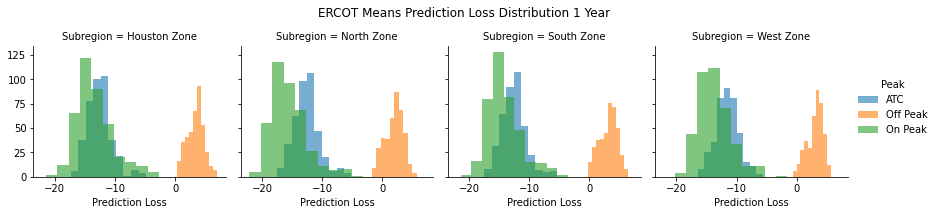

In [58]:
# os.chdir('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/')
#if 'figures' not in os.listdir('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/'):
#    os.makedirs('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/figures')

# plot to see
g = sns.FacetGrid(ercot_delta_avg, col="Subregion", hue='Peak', col_wrap=4)
g.map(plt.hist,'Prediction Loss', alpha=.6, rwidth=1).add_legend()
plt.subplots_adjust(top=.8)
g.fig.suptitle('ERCOT Means Prediction Loss Distribution 1 Year')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().invert_xaxis()
g.fig.savefig('/Users/jiyoojeong/desktop/C/Nephila/renewables/figures/ercot_mean_hist_1y.png')



## PLOT 2 - SD


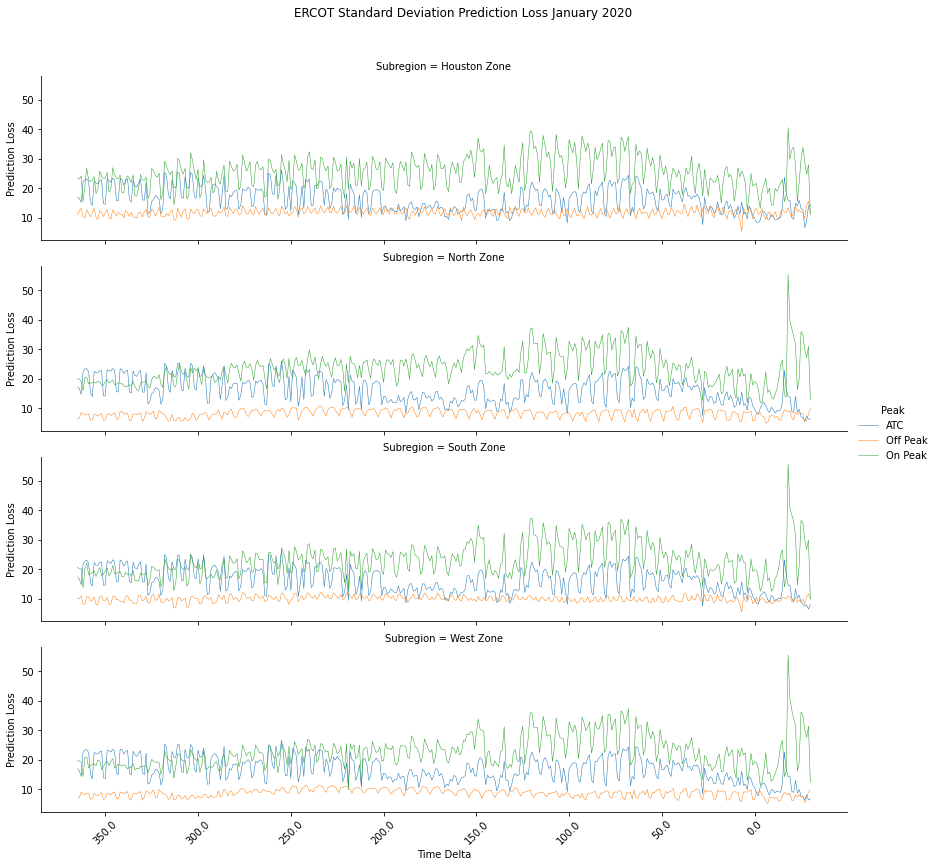

In [59]:
ercot_delta_sd = ercot_delta_sd.reset_index()
ercot_delta_sd['Time Delta'] = ercot_delta_sd['Time Delta'].dt.days
#print(ercot_delta_avg)
g2 = sns.FacetGrid(ercot_delta_sd, col="Subregion", hue='Peak', col_wrap=1, aspect=4)
g2.map(plt.plot, 'Time Delta', 'Prediction Loss', linewidth=.5).add_legend()
plt.subplots_adjust(top=.9)

#g2.fig.suptitle('ERCOT Standard Deviation Prediction Loss Over One Year Delta Time Away')  # , y=1.05)
g2.fig.suptitle('ERCOT Standard Deviation Prediction Loss January 2020')  # , y=1.05)
plt.gca().invert_xaxis() # Invert for time delta plot

for ax in g2.axes.flatten():
    ax.xaxis.set_visible(True)
    ax.xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)

#g2.fig.savefig('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/figures/ercot_sd_deltapredict.png')
g2.fig.savefig('/Users/jiyoojeong/desktop/C/Nephila/renewables/figures/ercot_sd_Jan2020.png')
g2

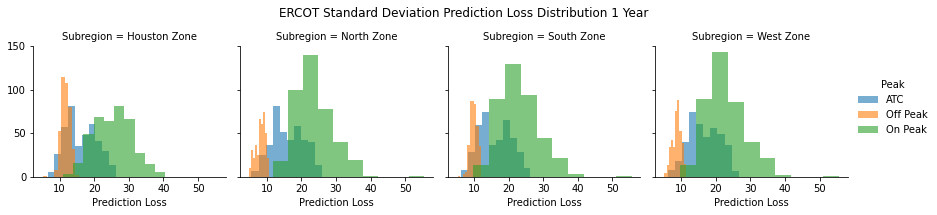

In [60]:
g2 = sns.FacetGrid(ercot_delta_sd, col="Subregion", hue='Peak', col_wrap=4)
#g2.map(plt.plot, 'Time Delta', 'Prediction Loss', linewidth=.5).add_legend()
g2.map(plt.hist,'Prediction Loss', alpha=.6, rwidth=1).add_legend()
plt.subplots_adjust(top=.8)
g2.fig.suptitle('ERCOT Standard Deviation Prediction Loss Distribution 1 Year')  # , y=1.05)
#plt.gca().invert_xaxis() # Invert for time delta plot

#g2.fig.savefig('/Users/jiyoojeong/desktop/C/raw/forwards/spg/ERCOT/figures/ercot_sd_deltapredict.png')
g2.fig.savefig('/Users/jiyoojeong/desktop/C/Nephila/renewables/figures/ercot_sd_hist_1y.png')
g2

## PLOT 3 MAX

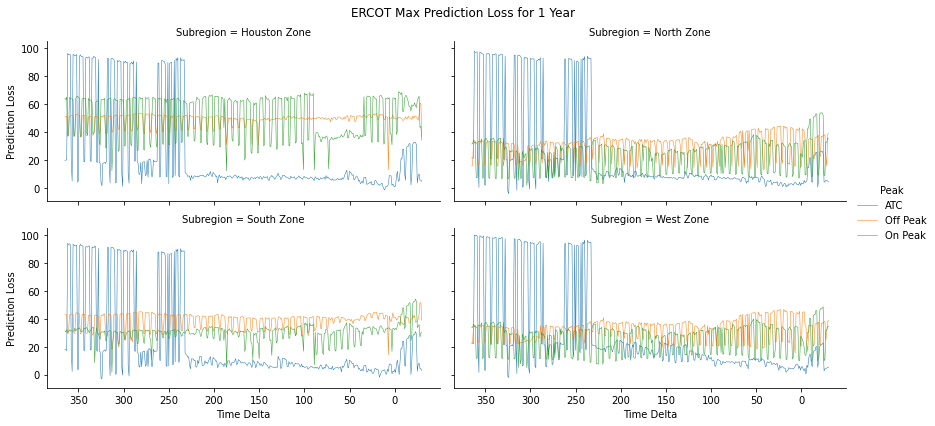

In [61]:
ercot_delta_max = ercot_delta_max.reset_index()
ercot_delta_max['Time Delta'] = ercot_delta_max['Time Delta'].dt.days
#print(ercot_delta_avg)
g3 = sns.FacetGrid(ercot_delta_max, col="Subregion", hue='Peak', col_wrap=2, aspect=2)
g3.map(plt.plot, 'Time Delta', 'Prediction Loss', linewidth=.5).add_legend()
plt.subplots_adjust(top=.9)

g3.fig.suptitle('ERCOT Max Prediction Loss for 1 Year')  # , y=1.05)
plt.gca().invert_xaxis()

g3.fig.savefig('/Users/jiyoojeong/desktop/C/Nephila/renewables/figures/ercot_max_1y.png')

g3

## PLOT 4 MIN

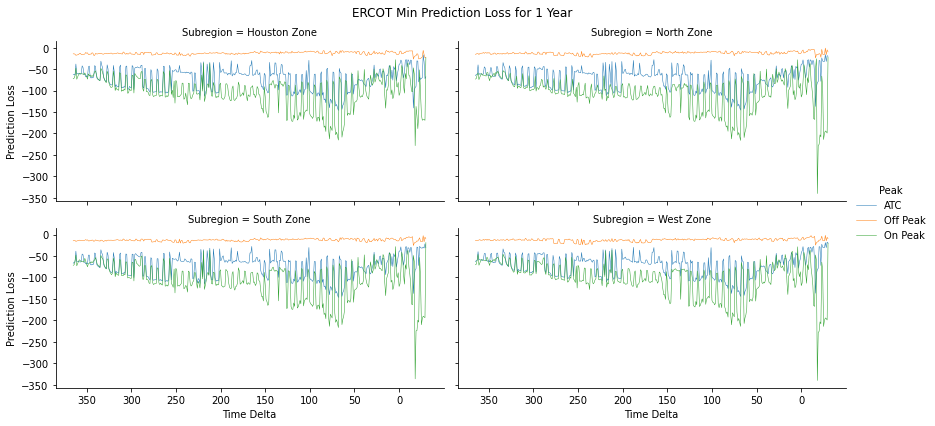

In [62]:
ercot_delta_min = ercot_delta_min.reset_index()
ercot_delta_min['Time Delta'] = ercot_delta_min['Time Delta'].dt.days
#print(ercot_delta_avg)
g4 = sns.FacetGrid(ercot_delta_min, col="Subregion", hue='Peak', col_wrap=2, aspect=2)
g4.map(plt.plot, 'Time Delta', 'Prediction Loss', linewidth=.5).add_legend()
plt.subplots_adjust(top=.9)

g4.fig.suptitle('ERCOT Min Prediction Loss for 1 Year')  # , y=1.05)
plt.gca().invert_xaxis()
    
g4.fig.savefig('/Users/jiyoojeong/desktop/C/Nephila/renewables/figures/ercot_min_1y.png')

g4

In [63]:
#plt.show()

## PLOT 5 - TEST DEALS

In [64]:
# use ercot_rt_h
ercot_rt_h

,date,price,Peak,Subregion,AsOfDate,Term,value,Prediction Loss
0,2013-06-01,29.885292,ATC,Houston Zone,2013-06-18,2013-06-01,57.108571,-27.223280
1,2013-06-01,29.885292,ATC,Houston Zone,2013-06-19,2013-06-01,48.011429,-18.126137
2,2013-06-01,29.885292,ATC,Houston Zone,2013-06-20,2013-06-01,48.077619,-18.192327
3,2013-06-01,29.885292,ATC,Houston Zone,2013-06-21,2013-06-01,45.779524,-15.894232
4,2013-06-01,29.885292,ATC,Houston Zone,2013-06-24,2013-06-01,46.164762,-16.279470
...,...,...,...,...,...,...,...,...
786834,2020-06-01,16.313958,Off Peak,West Zone,2019-01-07,2020-06-01,15.795300,0.518658
786835,2020-06-01,16.313958,Off Peak,West Zone,2019-01-08,2020-06-01,18.453800,-2.139842
786836,2020-06-01,16.313958,Off Peak,West Zone,2019-01-09,2020-06-01,18.254500,-1.940542
786837,2020-06-01,16.313958,Off Peak,West Zone,2019-01-10,2020-06-01,18.726400,-2.412442


In [65]:
# ONLY LOOK AT 
# ATC, 
# JUNE as of date before June 18, 2014 (one year prior to first as of date), 
# and only June Term Dates

rel_cols = ['AsOfDate', 'Peak', 'Term', 'Subregion', 'value', 'price', 'Prediction Loss'] 
#value is forward, price is real time

ercot_rt_h_june = ercot_rt_h.loc[(ercot_rt_h['Term'] > '2015-12-31')&\
                                 (ercot_rt_h['AsOfDate'] <= '2015-12-31')\
                                 &(ercot_rt_h['AsOfDate'] > '2015-01-01')\
                                 &(ercot_rt_h['Peak'] == 'ATC'), rel_cols]
ercot_rt_h_june['Term Month'] = ercot_rt_h_june['Term'].dt.month
ercot_rt_h_june = ercot_rt_h_june[ercot_rt_h_june['Term Month'] == 1]
ercot_rt_h_june['Term Year'] = ercot_rt_h_june['Term'].dt.year

ercot_rt_h_means = ercot_rt_h_june.groupby(['AsOfDate', 'Subregion', 'Term', 'Term Year']).mean().reset_index()
ercot_rt_h_means = ercot_rt_h_means.rename(columns={'value': 'Forward Price', 'price': 'Real Time Price'})

In [66]:
ercot_rt_h_means#[(ercot_rt_h_means['Term Year'] == 2014) & (ercot_rt_h_means['Subregion'] == 'Houston Zone')]

,AsOfDate,Subregion,Term,Term Year,Forward Price,Real Time Price,Prediction Loss,Term Month
0,2015-01-02,Houston Zone,2016-01-01,2016,38.641429,19.338986,-19.302442,1
1,2015-01-02,Houston Zone,2017-01-01,2017,41.009524,24.197236,-16.812288,1
2,2015-01-02,Houston Zone,2018-01-01,2018,42.115714,21.872472,-20.243242,1
3,2015-01-02,Houston Zone,2019-01-01,2019,43.246190,27.937056,-15.309135,1
4,2015-01-02,Houston Zone,2020-01-01,2020,43.092857,16.475778,-26.617079,1
...,...,...,...,...,...,...,...,...
4675,2015-12-31,West Zone,2016-01-01,2016,27.367619,15.377917,-11.989702,1
4676,2015-12-31,West Zone,2017-01-01,2017,30.046190,22.801681,-7.244510,1
4677,2015-12-31,West Zone,2018-01-01,2018,32.593810,22.282139,-10.311671,1
4678,2015-12-31,West Zone,2019-01-01,2019,33.972857,28.051097,-5.921760,1


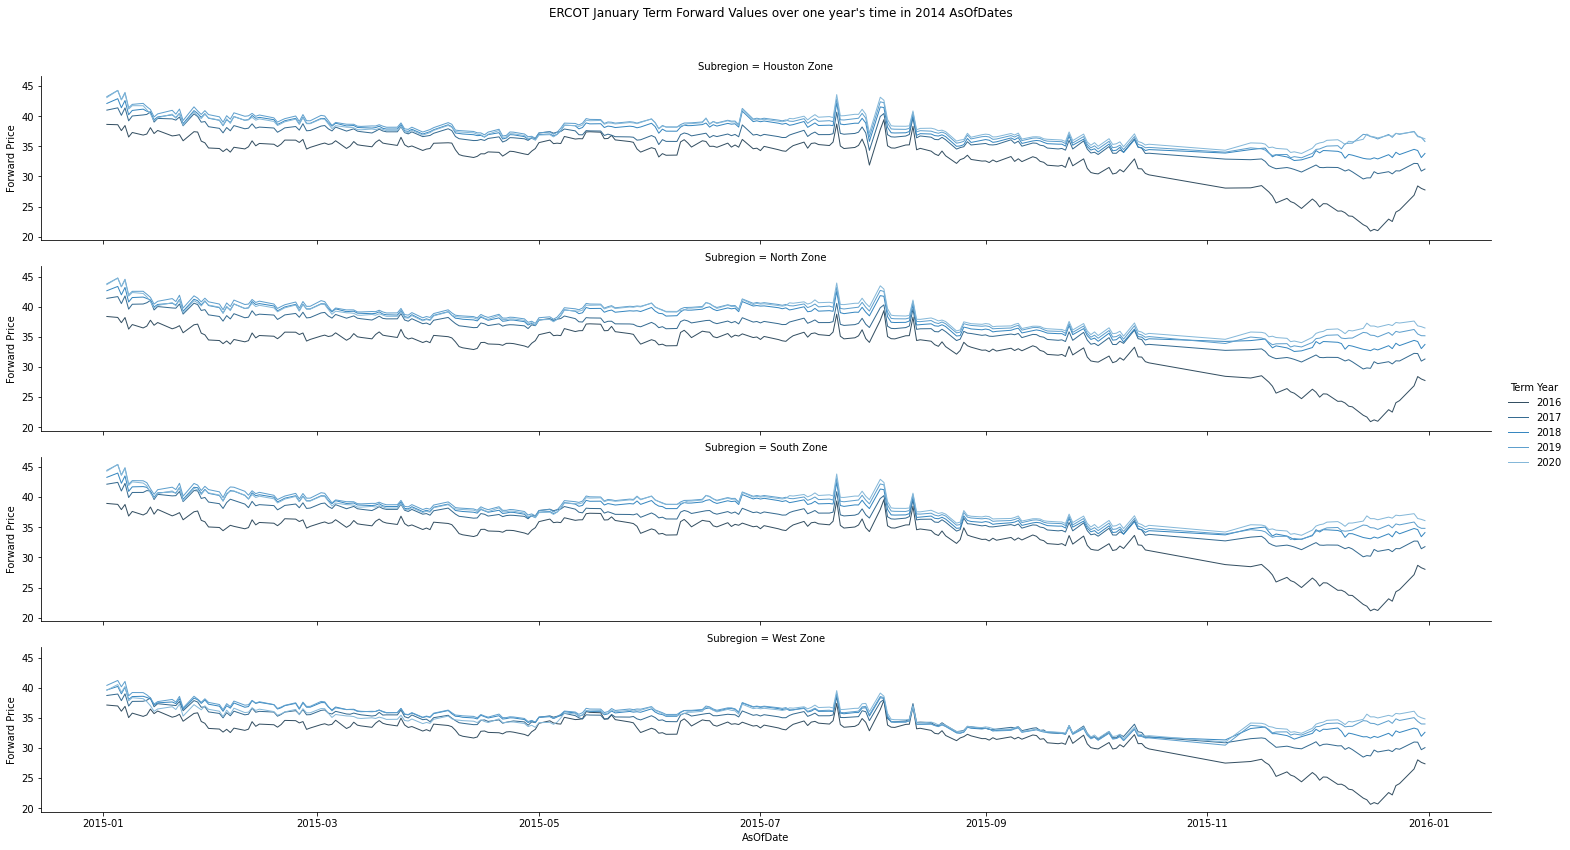

In [67]:
# plot to see
g5 = sns.FacetGrid(ercot_rt_h_means, col="Subregion", hue='Term Year', col_wrap=1, aspect=7, palette='Blues_d')
g5.map(plt.plot, 'AsOfDate', 'Forward Price', linewidth=1).add_legend()
plt.subplots_adjust(top=.9)
#g.figure(figsize=(10, 4))
g5.fig.suptitle('ERCOT January Term Forward Values over one year\'s time in 2014 AsOfDates')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().y_label('Prices')
#g5.fig.yaxis(label='Prices')
#plt.gca().invert_xaxis()
g.fig.savefig('/Users/jiyoojeong/desktop/C/nephila/renewables/figures/ercot_jan_test_means_vals_scatter.png')


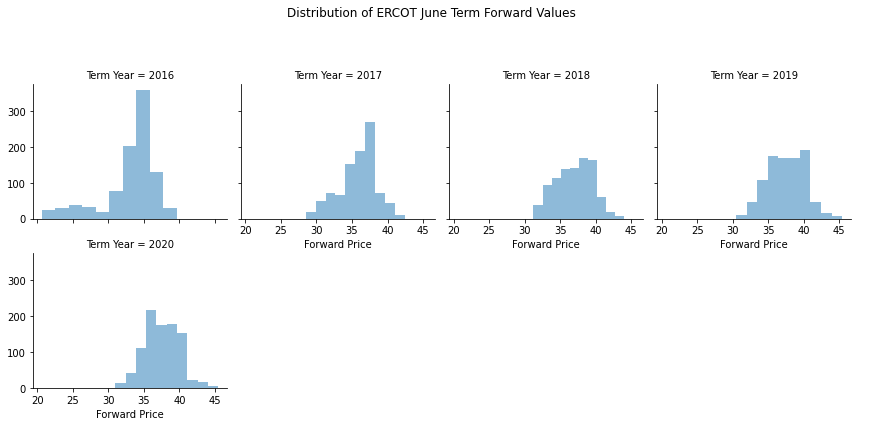

In [68]:
# plot to see
ercot_rt_h_means['AsOfMonth'] = ercot_rt_h_means['AsOfDate'].dt.month
g6 = sns.FacetGrid(ercot_rt_h_means, col="Term Year", col_wrap=4, palette='RdBu')
g6.map(plt.hist, 'Forward Price', linewidth=.5, alpha=.5).add_legend()
plt.subplots_adjust(top=.8)
#g.figure(figsize=(10, 4))
g6.fig.suptitle('Distribution of ERCOT June Term Forward Values')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().invert_xaxis()
g6.fig.savefig('/Users/jiyoojeong/desktop/C/nephila/renewables/figures/ercot_june_test_means_hist_vals.png')


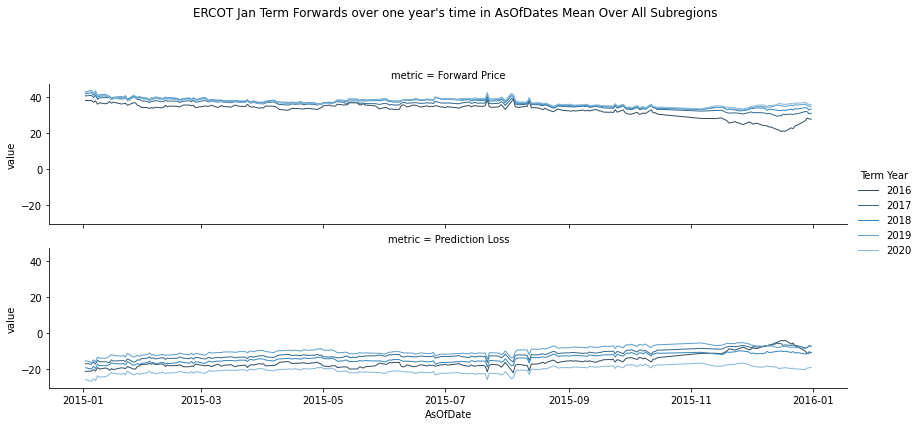

In [69]:
# plot to see
consolidated_rt_h_means = ercot_rt_h_means.groupby(['AsOfDate', 'Term', 'Term Year', 'Term Month']).mean().reset_index()
consolidated_rt_h_m_melt = pd.melt(consolidated_rt_h_means,id_vars=['AsOfDate', 'Term', 'Term Year'],
                           value_vars=['Forward Price', 'Prediction Loss'],
                           var_name='metric')
#print(consolidated_rt_h_m_melt)
g7 = sns.FacetGrid(consolidated_rt_h_m_melt, col="metric", hue='Term Year', col_wrap=1, aspect=4, palette='Blues_d')
g7.map(plt.plot, 'AsOfDate', 'value', linewidth=1).add_legend()
plt.subplots_adjust(top=.8)
#g.figure(figsize=(10, 4))
g7.fig.suptitle('ERCOT Jan Term Forwards over one year\'s time in AsOfDates Mean Over All Subregions')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().invert_xaxis()
g7.fig.savefig('/Users/jiyoojeong/desktop/C/nephila/renewables/figures/ercot_test_mean_jan_all_markets.png')


In [81]:
ercot_rt_h_means
consolidated_rt_h_means


,AsOfDate,Term,Term Year,Term Month,Forward Price,Real Time Price,Prediction Loss,AsOfMonth
0,2015-01-02,2016-01-01,2016,1,38.272381,16.749976,-21.522405,1
1,2015-01-02,2017-01-01,2017,1,40.810238,23.638875,-17.171363,1
2,2015-01-02,2018-01-01,2018,1,41.917381,22.439497,-19.477884,1
3,2015-01-02,2019-01-01,2019,1,42.967738,27.445201,-15.522537,1
4,2015-01-02,2020-01-01,2020,1,42.662857,16.590035,-26.072822,1
...,...,...,...,...,...,...,...,...
1165,2015-12-31,2016-01-01,2016,1,27.732857,16.749976,-10.982881,12
1166,2015-12-31,2017-01-01,2017,1,31.098810,23.638875,-7.459935,12
1167,2015-12-31,2018-01-01,2018,1,33.567024,22.439497,-11.127527,12
1168,2015-12-31,2019-01-01,2019,1,34.946310,27.445201,-7.501108,12


<AxesSubplot:title={'center':'metric = Forward Price'}, xlabel='AsOfDate', ylabel='Real Time Price'>

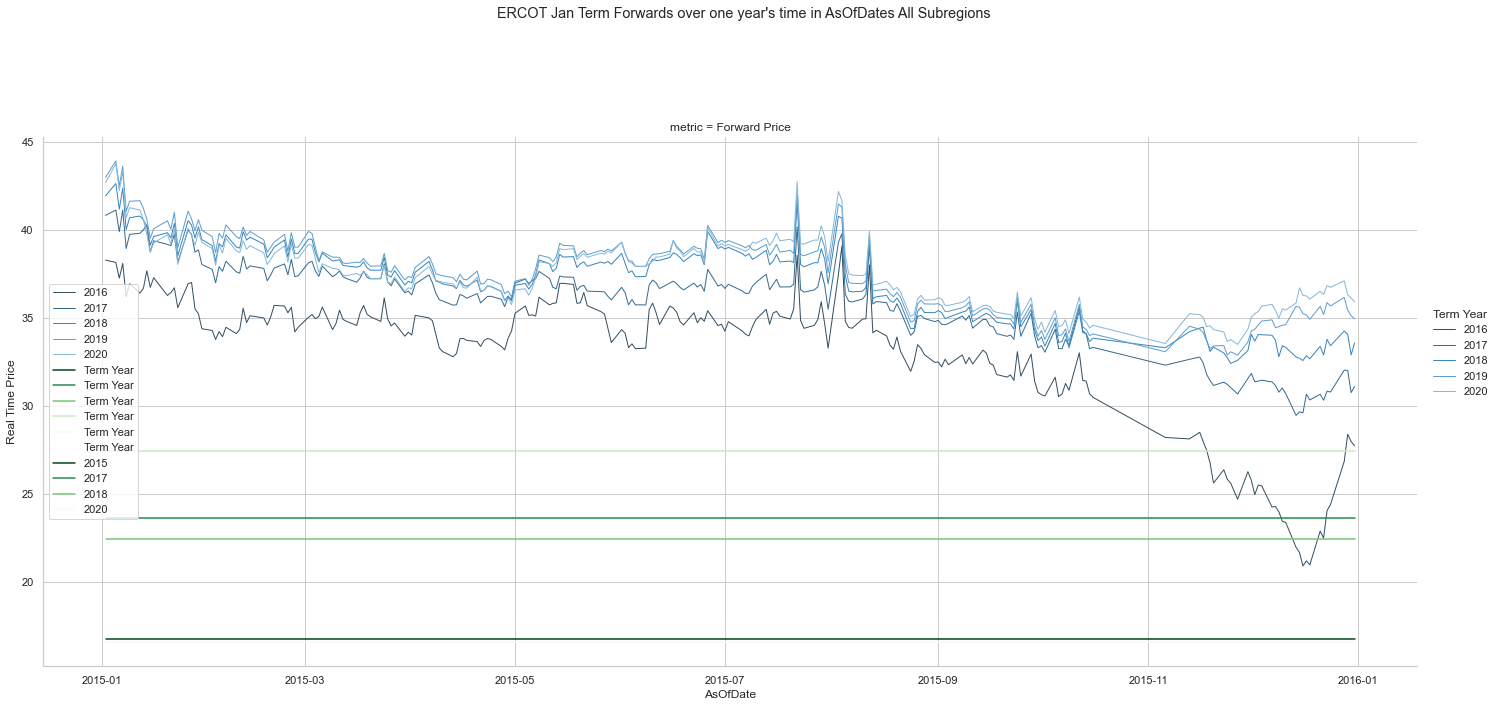

In [98]:
# plot to see
consolidated_rt_h_means = ercot_rt_h_means.groupby(['AsOfDate', 'Term', 'Term Year', 'Term Month']).mean().reset_index()
consolidated_rt_h_m_melt = pd.melt(consolidated_rt_h_means,id_vars=['AsOfDate', 'Term', 'Term Year'],
                           value_vars=['Forward Price', 'Prediction Loss'],
                           var_name='metric')
consolidated_means = consolidated_rt_h_m_melt.copy()
consolidated_rt_h_m_melt=consolidated_rt_h_m_melt[consolidated_rt_h_m_melt['metric'] == 'Forward Price']
consolidated_means_fp = consolidated_rt_h_m_melt.copy()
#print(consolidated_rt_h_m_melt)
g7 = sns.FacetGrid(consolidated_rt_h_m_melt, col="metric", hue='Term Year', height=10, aspect=2, palette='Blues_d')
g7.map(plt.plot, 'AsOfDate', 'value', linewidth=1).add_legend()
plt.subplots_adjust(top=.8)
#g.figure(figsize=(10, 4))
g7.fig.suptitle('ERCOT Jan Term Forwards over one year\'s time in AsOfDates All Subregions')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().invert_xaxis()
only_rt = consolidated_rt_h_means[['AsOfDate', 'Real Time Price', 'Term Year']].drop_duplicates()
sns.lineplot(data=only_rt, x='AsOfDate', y='Real Time Price', hue='Term Year', palette='Greens_r')
#g7.fig.savefig('/Users/jiyoojeong/desktop/C/nephila/renewables/figures/ercot_meansFV_test_jan2015.png')


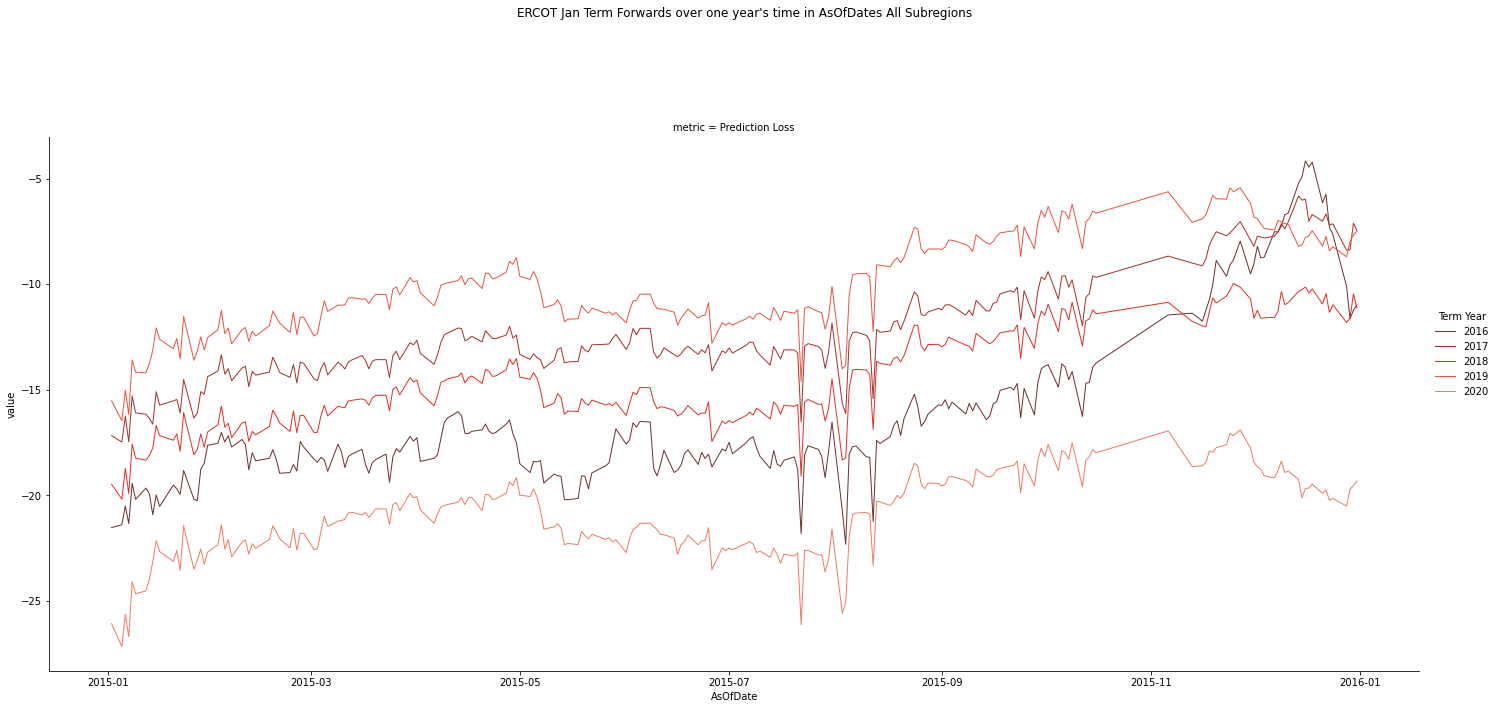

In [72]:
# plot to see
consolidated_rt_h_means = ercot_rt_h_means.groupby(['AsOfDate', 'Term', 'Term Year', 'Term Month']).mean().reset_index()
consolidated_rt_h_m_melt = pd.melt(consolidated_rt_h_means,id_vars=['AsOfDate', 'Term', 'Term Year'],
                           value_vars=['Forward Price', 'Prediction Loss'],
                           var_name='metric')
consolidated_means = consolidated_rt_h_m_melt.copy()
consolidated_rt_h_m_melt=consolidated_rt_h_m_melt[consolidated_rt_h_m_melt['metric'] == 'Prediction Loss']
consolidated_means_pl = consolidated_rt_h_m_melt.copy()
#print(consolidated_rt_h_m_melt)
g7 = sns.FacetGrid(consolidated_rt_h_m_melt, col="metric", hue='Term Year', height=10, aspect=2, palette='Reds_d')
g7.map(plt.plot, 'AsOfDate', 'value', linewidth=1).add_legend()
plt.subplots_adjust(top=.8)
#g.figure(figsize=(10, 4))
g7.fig.suptitle('ERCOT Jan Term Forwards over one year\'s time in AsOfDates All Subregions')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().invert_xaxis()
g7.fig.savefig('/Users/jiyoojeong/desktop/C/nephila/renewables/figures/ercot_meansPL_test_jan2015.png')


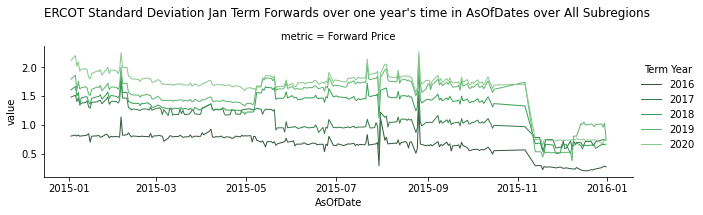

In [73]:
# plot to see
consolidated_rt_h_sds = ercot_rt_h_means.groupby(['AsOfDate', 'Term', 'Term Year', 'Term Month']).std().reset_index()
consolidated_rt_h_m_melt = pd.melt(consolidated_rt_h_sds,id_vars=['AsOfDate', 'Term', 'Term Year'],
                           value_vars=['Forward Price', 'Prediction Loss'],
                           var_name='metric')
#print(consolidated_rt_h_m_melt)
consolidated_sds= consolidated_rt_h_m_melt.copy()
consolidated_rt_h_m_melt=consolidated_rt_h_m_melt[consolidated_rt_h_m_melt['metric'] == 'Forward Price']
consolidated_sds_FV = consolidated_rt_h_m_melt.copy()

g7 = sns.FacetGrid(consolidated_rt_h_m_melt, col="metric", hue='Term Year', col_wrap=1, aspect=3, palette='Greens_d')
g7.map(plt.plot, 'AsOfDate', 'value', linewidth=1, label='Term Year').add_legend()
plt.subplots_adjust(top=.8)
#g.figure(figsize=(10, 4))
g7.fig.suptitle('ERCOT Standard Deviation Jan Term Forwards over one year\'s time in AsOfDates over All Subregions')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().invert_xaxis()
g7.fig.savefig('/Users/jiyoojeong/desktop/C/nephila/renewables/figures/ercot_test_SD_Jan_all_markets.png')


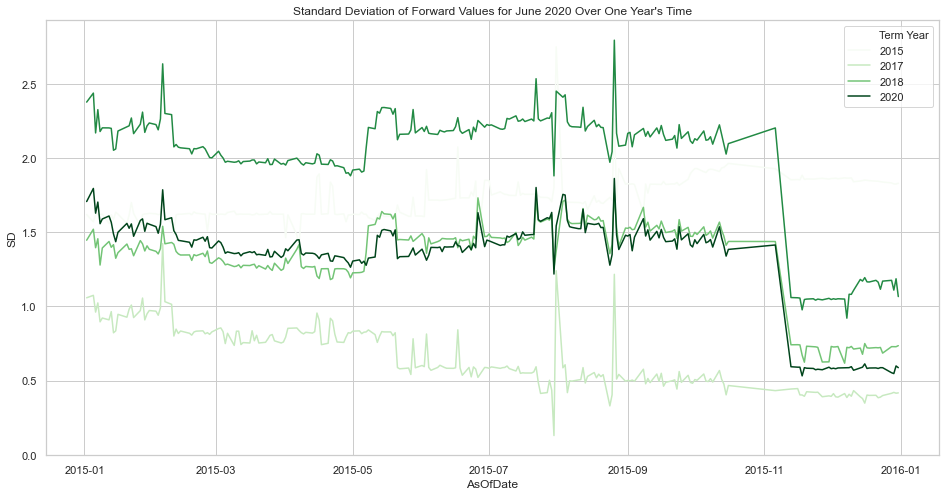

In [74]:
only_vals = consolidated_sds[consolidated_sds['metric']=='Prediction Loss'].rename(columns={'value': 'SD'})
#plt.plot('AsOfDate','SD',data=only_vals, label='Term', linewidth='.5')

sns.set(rc={'figure.figsize':(16,8)})
sns.set_style("whitegrid")
a = sns.lineplot(data=only_vals, x='AsOfDate', y='SD', hue='Term Year', palette='Greens')
plt.title('Standard Deviation of Forward Values for June 2020 Over One Year\'s Time')
plt.savefig('/Users/jiyoojeong/desktop/C/nephila/renewables/figures/ercot_test_SDPL_JAN_line.png')


# plot to see
g8 = sns.FacetGrid(consolidated_rt_h_m_melt, col="metric", col_wrap=1, aspect=4, palette='RdBu')
g8.map(plt.hist, 'value', alpha=.5).add_legend()
plt.subplots_adjust(top=.8)
#g.figure(figsize=(10, 4))
g8.fig.suptitle('Distribution of ERCOT June Term Forward Prediction Loss')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().invert_xaxis()

for ax in g8.axes.flatten():
    ax.tick_params(labelbottom=True)
    
g8.fig.savefig('/Users/jiyoojeong/desktop/C/nephila/renewables/figures/ercot_means_test_hist.png')


Can we take the P90/worst case/best case/expected forward price based off this volatility, and use Prius to price them? Hint: we can use the Prius API “Imposed Intermediate Results” function to impose a forward curve

In [134]:
ercot_rt_h_means.groupby(['AsOfDate', 'Term', 'Term Year', 'Term Month']).count()

Subregion  Forward Price  \
AsOfDate   Term       Term Year Term Month                             
2015-01-02 2016-01-01 2016      1                   4              4   
           2017-01-01 2017      1                   4              4   
           2018-01-01 2018      1                   4              4   
           2019-01-01 2019      1                   4              4   
           2020-01-01 2020      1                   4              4   
...                                               ...            ...   
2015-12-31 2016-01-01 2016      1                   4              4   
           2017-01-01 2017      1                   4              4   
           2018-01-01 2018      1                   4              4   
           2019-01-01 2019      1                   4              4   
           2020-01-01 2020      1                   4              4   

                                            Real Time Price  Prediction Loss  \
AsOfDate   Term       Term Year Term Month                                     
2015-01-02 2016-01-01 2016      1                         4                4   
           2017-01-01 2017      1                         4                4   
           2018-01-01 2018      1                         4                4   
           2019-01-01 2019      1                         4                4   
           2020-01-01 2020      1                         4                4   
...                                                     ...              ...   
2015-12-31 2016-01-01 2016      1                         4                4   
           2017-01-01 2017      1                         4                4   
           2018-01-01 2018      1                         4                4   
           2019-01-01 2019      1                         4                4   
           2020-01-01 2020      1                         4                4   

                                            AsOfMonth  
AsOfDate   Term       Term Year Term Month             
2015-01-02 2016-01-01 2016      1                   4  
           2017-01-01 2017      1                   4  
           2018-01-01 2018      1                   4  
           2019-01-01 2019      1                   4  
           2020-01-01 2020      1                   4  
...                                               ...  
2015-12-31 2016-01-01 2016      1                   4  
           2017-01-01 2017      1                   4  
           2018-01-01 2018      1                   4  
           2019-01-01 2019      1                   4  
           2020-01-01 2020      1                   4  

[1170 rows x 5 columns]

In [140]:
# when do we usually price or buy a deal?
# that way I can try to predict the best/worst case from that as of date
range1 = ['2015-1-1','2015-3-31']
range2 = ['2015-6-1', '2015-9-30']
range3 = ['2015-10-31', '2015-12-31']

def inrangemax(df, r):
    return df.loc[(df['AsOfDate']>=r[0]) & (df['AsOfDate']<=r[1]), 'Prediction Loss'].min()

def inrangemin(df, r):
    return df.loc[(df['AsOfDate']>=r[0]) & (df['AsOfDate']<=r[1]), 'Prediction Loss'].max()


date1 = consolidated_rt_h_means.loc[(inrangemin(consolidated_rt_h_sds, range1) == consolidated_rt_h_sds['Prediction Loss']) &\
                           (consolidated_rt_h_sds['AsOfDate'] >= range1[0]) & (consolidated_rt_h_sds['AsOfDate'] <= range1[1]),
                           'AsOfDate'].values[0]
date2 = consolidated_rt_h_means.loc[(inrangemin(consolidated_rt_h_sds, range2) == consolidated_rt_h_sds['Prediction Loss']) &\
                           (consolidated_rt_h_sds['AsOfDate'] >= range2[0]) & (consolidated_rt_h_sds['AsOfDate'] <= range2[1]),
                           'AsOfDate'].values[0]
date3 = consolidated_rt_h_means.loc[(inrangemin(consolidated_rt_h_sds, range3) == consolidated_rt_h_sds['Prediction Loss']) &\
                           (consolidated_rt_h_sds['AsOfDate'] >= range3[0]) & (consolidated_rt_h_sds['AsOfDate'] <= range3[1]),
                           'AsOfDate'].values[0]

date1, date2, date3

(numpy.datetime64('2015-02-05T00:00:00.000000000'),
 numpy.datetime64('2015-08-26T00:00:00.000000000'),
 numpy.datetime64('2015-11-06T00:00:00.000000000'))

In [141]:
#date1 = datetime.datetime.strptime('2015-11-30', '%Y-%m-%d')# low vol at year end
#date2 = datetime.datetime.strptime('2015-01-30', '%Y-%m-%d') # high vol at year start
#date3 = datetime.datetime.strptime('2015-8-31', '%Y-%m-%d') # high vol here

date1df = consolidated_means[consolidated_means['AsOfDate'] == date1]

date2df = consolidated_means[consolidated_means['AsOfDate'] == date2]

date3df = consolidated_means[consolidated_means['AsOfDate'] == date3]
#consolidated_rt_h_means

In [142]:
def highlight_max1(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    losses = date1pivot['Prediction Loss']
    #print(losses)
    is_max = np.abs(losses) == np.abs(losses).max()
    colors =  ['background-color: red; color: white' if is_max[i] else '' for i in np.arange(0, len(is_max))]
    is_min = np.abs(losses) == np.abs(losses).min()
    #print(is_max)
    colors = ['background-color: green; color: white' if is_min[i] else colors[i] for i in np.arange(0, len(is_min))]
    return colors

def highlight_max2(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    losses = date2pivot['Prediction Loss']
    #print(losses)
    is_max = np.abs(losses) == np.abs(losses).max()
    colors =  ['background-color: red; color: white' if is_max[i] else '' for i in np.arange(0, len(is_max))]
    is_min = np.abs(losses) == np.abs(losses).min()
    #print(is_max)
    colors = ['background-color: green; color: white' if is_min[i] else colors[i] for i in np.arange(0, len(is_min))]
    return colors

def highlight_max3(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    losses = date3pivot['Prediction Loss']
    #print(losses)
    is_max = np.abs(losses) == np.abs(losses).max()
    colors =  ['background-color: red; color: white' if is_max[i] else '' for i in np.arange(0, len(is_max))]
    is_min = np.abs(losses) == np.abs(losses).min()
    #print(is_max)
    colors = ['background-color: green; color: white' if is_min[i] else colors[i] for i in np.arange(0, len(is_min))]
    return colors

In [143]:
date2df

,AsOfDate,Term,Term Year,metric,value
815,2015-08-26,2016-01-01,2016,Forward Price,33.475000
816,2015-08-26,2017-01-01,2017,Forward Price,35.077500
817,2015-08-26,2018-01-01,2018,Forward Price,35.357381
818,2015-08-26,2019-01-01,2019,Forward Price,35.780714
819,2015-08-26,2020-01-01,2020,Forward Price,36.059881
1985,2015-08-26,2016-01-01,2016,Prediction Loss,-16.725024
1986,2015-08-26,2017-01-01,2017,Prediction Loss,-11.438625
1987,2015-08-26,2018-01-01,2018,Prediction Loss,-12.917884
1988,2015-08-26,2019-01-01,2019,Prediction Loss,-8.335513
1989,2015-08-26,2020-01-01,2020,Prediction Loss,-19.469846


In [144]:
date1pivot = date1df.pivot(index=['AsOfDate', 'Term'], columns='metric', values='value')#[['Forward Price', 'Prediction Loss']]

date2pivot = date2df.pivot(index=['AsOfDate', 'Term'], columns='metric', values='value')#[['Forward Price', 'Prediction Loss']]

date3pivot = date3df.pivot(index=['AsOfDate', 'Term'], columns='metric', values='value')#[['Forward Price', 'Prediction Loss']]

date3pivot

metric                 Forward Price  Prediction Loss
AsOfDate   Term                                      
2015-11-06 2016-01-01      28.207262       -11.457286
           2017-01-01      32.311071        -8.672196
           2018-01-01      33.299286       -10.859789
           2019-01-01      33.069881        -5.624680
           2020-01-01      33.536190       -16.946156

In [145]:
#cm = sns.light_palette("red", as_cmap=True)

s1 = date1pivot.style.apply(highlight_max1, subset=['Forward Price']).bar(subset=['Prediction Loss'], align='mid', color=['#ffe0e0'])
s2 = date2pivot.style.apply(highlight_max2, subset=['Forward Price']).bar(subset=['Prediction Loss'], align='mid', color=['#ffe0e0'])
s3 = date3pivot.style.apply(highlight_max3, subset=['Forward Price']).bar(subset=['Prediction Loss'], align='mid', color=['#ffe0e0'])

In [146]:
s1

In [147]:
s2

In [148]:
s3

In [181]:
merged = pd.merge(date1pivot.reset_index(), date2pivot.reset_index(), on='Term')
merged = pd.merge(merged, date3pivot.reset_index(), on='Term')
merged['Prediction Loss Difference'] = merged['Prediction Loss_x'] - merged['Prediction Loss_y']
merged['Forward Price Difference'] = merged['Forward Price_x'] - merged['Forward Price_y']

In [185]:
m #= merged[['Term', 'AsOfDate_x', 'AsOfDate_y', 'Forward Price_x', 'Forward Price_y', 'Forward Price Difference', 
           #'Prediction Loss_x', 'Prediction Loss_y', 'Prediction Loss Difference']]
m = merged.copy()

In [186]:
m['AsOfDate_x'][0], m['Forward Price_x'].std(), m['AsOfDate_y'][0], m['Forward Price_y'].std(), m['AsOfDate'][0], m['Forward Price'].std()
# FV SD for as of 11/30 and 1/30 and 8/31 -- (3.2512674950773413, 2.262517477475999, 1.4240268646826395)

# Timestamp('2015-02-05 00:00:00'), 2.249679212141074
# Timestamp('2015-08-26 00:00:00'), 1.009897509870272 ** LEAST VOLATILE
# Timestamp('2015-11-06 00:00:00'), 2.2157614248590547


(Timestamp('2015-02-05 00:00:00'),
 2.249679212141074,
 Timestamp('2015-08-26 00:00:00'),
 1.009897509870272,
 Timestamp('2015-11-06 00:00:00'),
 2.2157614248590547)

In [189]:
m['AsOfDate_x'][0], m['Prediction Loss_x'].std(), m['AsOfDate_y'][0], m['Prediction Loss_y'].std(), m['AsOfDate'][0], m['Prediction Loss'].std()
# MEAN PL for 11/30 = -10.415069047619042
# MEAN PL 1/30 = -16.844378571428564
# MEAN PL 8/21 = -13.495640476190468

# MEAN PL
# Timestamp('2015-02-05 00:00:00'), -16.385878571428563,
# Timestamp('2015-08-26 00:00:00'), -13.777378571428565,
# Timestamp('2015-11-06 00:00:00'), -10.712021428571422 ** MOST ACCURATE

# SD PL
#Timestamp('2015-02-05 00:00:00'), 3.789348970044771, ** LEAST VOLATILE
#Timestamp('2015-08-26 00:00:00'), 4.385065675002104,
#Timestamp('2015-11-06 00:00:00'), 4.167841736891567)





(Timestamp('2015-02-05 00:00:00'),
 3.789348970044771,
 Timestamp('2015-08-26 00:00:00'),
 4.385065675002104,
 Timestamp('2015-11-06 00:00:00'),
 4.167841736891567)

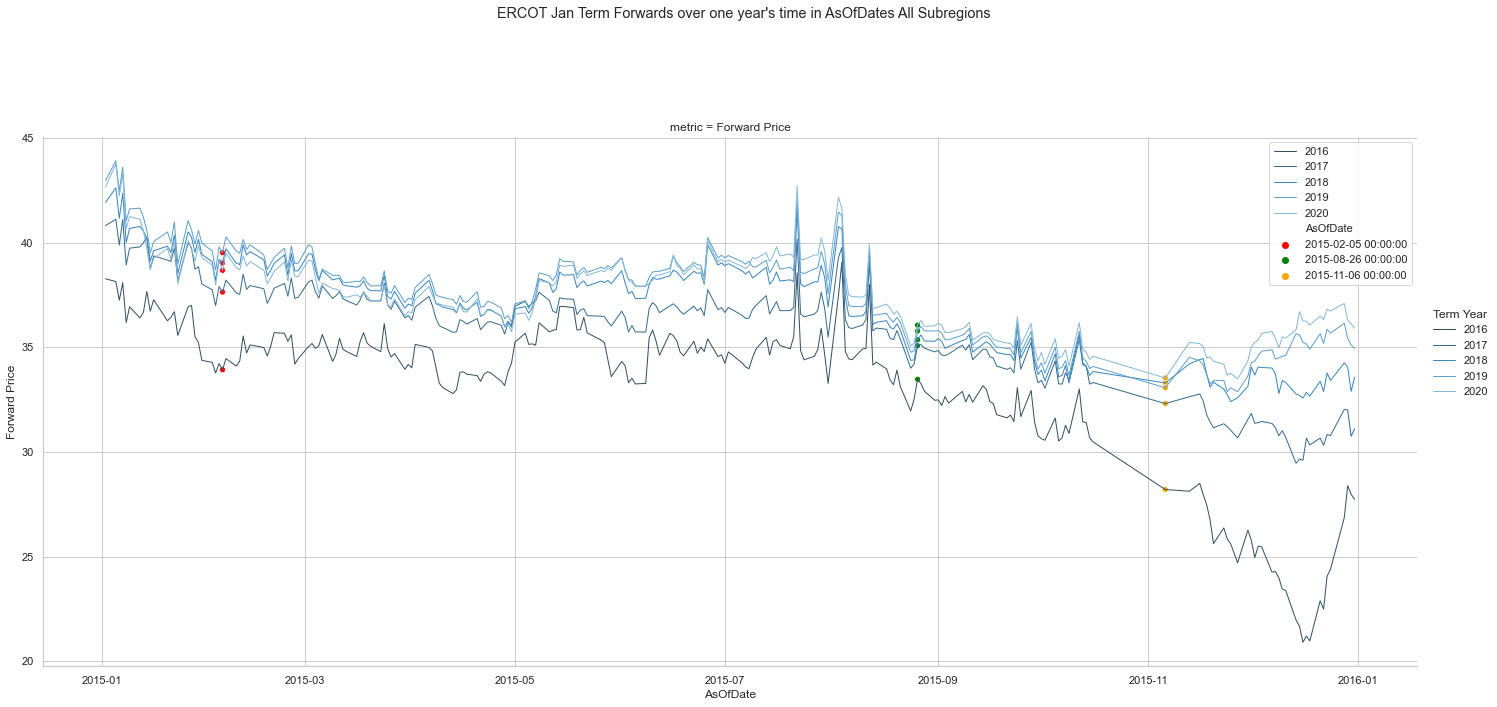

In [190]:
# plot to see
consolidated_rt_h_means = ercot_rt_h_means.groupby(['AsOfDate', 'Term', 'Term Year', 'Term Month']).mean().reset_index()
consolidated_rt_h_m_melt = pd.melt(consolidated_rt_h_means,id_vars=['AsOfDate', 'Term', 'Term Year'],
                           value_vars=['Forward Price', 'Prediction Loss'],
                           var_name='metric')
consolidated_means = consolidated_rt_h_m_melt.copy()
consolidated_rt_h_m_melt=consolidated_rt_h_m_melt[consolidated_rt_h_m_melt['metric'] == 'Forward Price']
consolidated_means_fp = consolidated_rt_h_m_melt.copy()
#print(consolidated_rt_h_m_melt)
g7 = sns.FacetGrid(consolidated_rt_h_m_melt, col="metric", hue='Term Year', height=10, aspect=2, palette='Blues_d')
g7.map(plt.plot, 'AsOfDate', 'value', linewidth=1).add_legend()
plt.subplots_adjust(top=.8)
#g.figure(figsize=(10, 4))
g7.fig.suptitle('ERCOT Jan Term Forwards over one year\'s time in AsOfDates All Subregions')  # , y=1.05)
# g.fig.title('Ercot Means')
#plt.gca().invert_xaxis()
only_rt = consolidated_rt_h_means[['AsOfDate', 'Real Time Price', 'Term Year']].drop_duplicates()
datelist = [date1, date2, date3]
fvs = consolidated_rt_h_means[consolidated_rt_h_means['AsOfDate'].isin(datelist)]
sns.scatterplot(data=fvs, x='AsOfDate', y='Forward Price', hue='AsOfDate', palette=['red', 'green', 'orange'])
#a.text(x='AsOfDate', y='Forward Price', s='Forward Price')
g7.fig.savefig('/Users/jiyoojeong/desktop/C/nephila/renewables/figures/ercot_meansFV_w_deals.png')
